In [9]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    runs_on_gpu = True
else:
    device = torch.device('cpu')
    runs_on_gpu = False
print(f"Runs on {device.type}")

Runs on cpu


In [3]:
data = pd.read_json('recipes.json')
data.dropna(subset=['rating'], inplace=True, ignore_index=True)
print(data.dropna(how='any', inplace=False, ignore_index=True).shape)
data.info()

(10608, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20100 entries, 0 to 20099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   directions   20100 non-null  object             
 1   fat          15901 non-null  float64            
 2   date         20100 non-null  datetime64[ns, UTC]
 3   categories   20100 non-null  object             
 4   calories     15969 non-null  float64            
 5   desc         13484 non-null  object             
 6   protein      15922 non-null  float64            
 7   rating       20100 non-null  float64            
 8   title        20100 non-null  object             
 9   ingredients  20100 non-null  object             
 10  sodium       15967 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), object(5)
memory usage: 1.7+ MB


In [4]:
data.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0


In [5]:
mandatory_columns = ['directions', 'date', 'categories', 'title', 'ingredients']
optional_columns = ['fat', 'calories', 'desc', 'protein', 'sodium']
numerical_columns = ['fat', 'calories', 'protein', 'sodium']
textual_columns = ['title', 'directions', 'desc']

In [6]:
data['desc'] = data['desc'].fillna('')
assert(data['desc'].isna().sum() == 0)

data['directions'] = data['directions'].apply(lambda x: ' '.join(x))
assert(data['directions'].isna().sum() == 0)

In [10]:
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

In [7]:
data.to_json('preprocessed_recipes.json')

<Axes: xlabel='rating'>

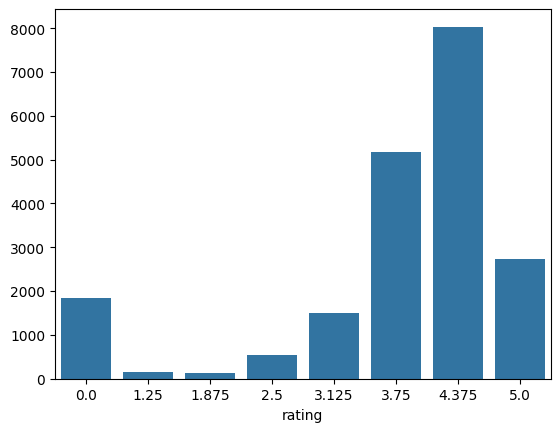

In [8]:
ratings = data['rating']
data.drop(columns=['rating'])
rating_value_counts = ratings.value_counts()
sns.barplot(x=rating_value_counts.index, y=rating_value_counts.values)

# 3 Basic Project
The basic project will consist of solving a regression task, comparing the performance obtained using different vectorizations of the documents and at least two different machine learning strategies, as described below. 

You should use the information in the directions and/or desc variables for all steps of the project, possibly combining this information with metadata from other variables. You should use appropriate metrics for evaluating this task. The performance of the different methods should be estimated using a validation methodology, which you should also explain in the documentation. You should provide a description of the methodology used and analyze the performance obtained according to the input variables.
Keep in mind that the goal is to describe the work carried out and critically analyze the results obtained. Support this with graphs or other representations you consider appropriate. There is no need to describe the algorithms used, but you should explain how you tuned their parameters.

## Baseline

In [20]:
mean_rating = np.mean(data['rating'])
baseline_mse = np.mean((data['rating'] - mean_rating)**2)
print(f"Mean rating: {mean_rating} and MSE: {baseline_mse}")

Mean rating: 3.7130597014925373 and MSE: 1.8039448048934432


In [21]:
most_used_rating = 4.375
mse = np.mean((data['rating'] - most_used_rating)**2)
print(f"MSE: {mse}")

MSE: 2.242109763681592


## 3.1
Analysis of input variables. Visualize the relationship between the output variable and some categories in the categories variable and explain their potential relevance to the problem.

In [22]:
import matplotlib.pyplot as plt

In [23]:
all_categories = data['categories'].explode().unique()
print(len(all_categories))

675


In [24]:
categories = {category: data['categories'].apply(lambda x: 1 if category in x else 0) for category in all_categories}
assert(len(categories) == len(all_categories))

In [25]:
categories_and_rating = pd.DataFrame(categories)
categories_and_rating['rating'] = data['rating']
categories_and_rating

,Sandwich,Bean,Fruit,Tomato,turkey,Vegetable,Kid-Friendly,Apple,Lentil,Lettuce,...,Quiche,Anthony Bourdain,Marinade,Pacific Palisades,Alaska,Mississippi,Crêpe,New Hampshire,Sourdough,rating
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,2.500
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.375
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.750
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.000
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.125
20096,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4.375
20097,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4.375
20098,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.375


In [26]:
grouped_by_rating = categories_and_rating.groupby(['rating'])
normalizer = grouped_by_rating.size() / len(categories_and_rating)
assert(abs(normalizer.sum() - 1)  < 0.001)
normalizer

rating
0.000    0.091990
1.250    0.008159
1.875    0.006169
2.500    0.026667
3.125    0.074080
3.750    0.257413
4.375    0.399652
5.000    0.135871
dtype: float64

In [27]:
normalize_column = lambda x: x / normalizer / (x / normalizer).sum()
relations = grouped_by_rating.sum().apply(normalize_column)
relations = relations.astype(float)
relations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 0.0 to 5.0
Columns: 675 entries, Sandwich to Sourdough
dtypes: float64(675)
memory usage: 42.2 KB


<Axes: ylabel='rating'>

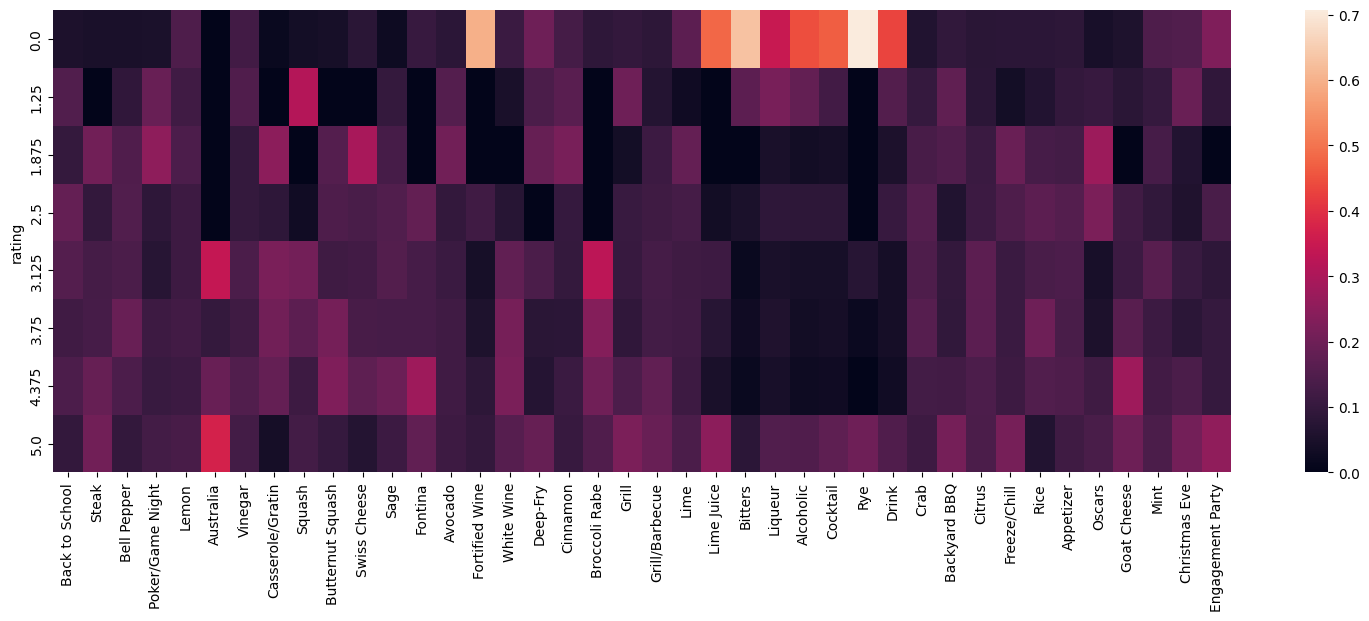

In [28]:
plt.figure(figsize=(19, 6))
# To get the boundaries of the plot, I just looked at the plot without the boundaries and searched for interesting looking areas
sns.heatmap(relations.iloc[:,150:190])
# From this plot for example one can get some interesting insights
# For example, the category 'Australia' seems to have good ratings
# While categories like 'Lime Juice', 'Bitters', 'Alcoholic' or 'Cocktail' seem to have bad ratings
# Other categories like 'Lemon' or 'Vinegar' seem to have no big impact on the rating

Alaska
0    20098
1        2
dtype: int64

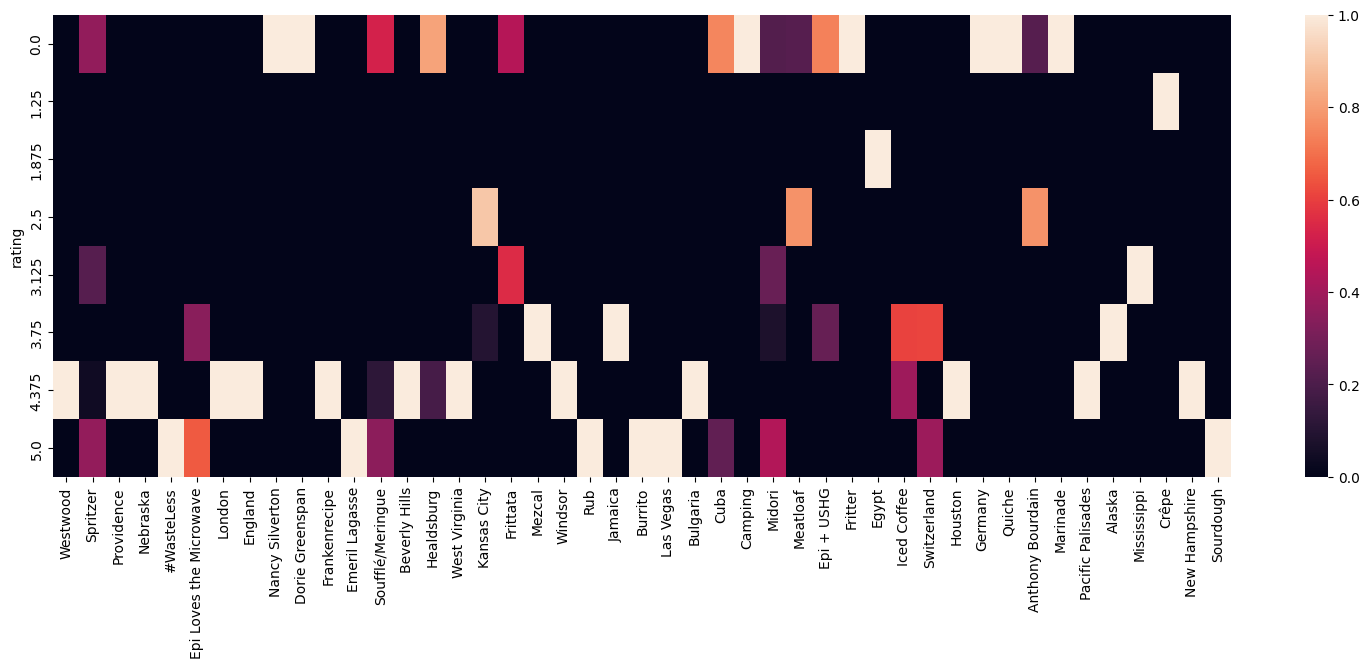

In [29]:
plt.figure(figsize=(19, 6))
sns.heatmap(relations.iloc[:,630:])
# This plot show some very significant relations, for example for 'Alaska'
# All recipes with 'Alaska' in the category seem to have a rating of 3.75
# But one needs to be careful with such conclusions, as the number of recipes with 'Alaska' is very low (2 of 20111)
categories_and_rating.groupby(['Alaska']).size()

## 3.2
Implementation of a pipeline for text preprocessing. For this task, you may use common libraries (NLTK, Gensim, or SpaCy), or any other library you deem appropriate. Keep in mind that when working with transformers, the text is passed without preprocessing.

In [30]:
from sklearn.decomposition import PCA

In [31]:
pca = PCA()
pca.fit(data[numerical_columns].dropna())

PCA()

[9.98156996e-01 1.81442847e-03 2.82392361e-05 3.36622899e-07]
[[ 0.04137003  0.73235479  0.0058433   0.67964022]
 [-0.11266857 -0.67246304  0.01506835  0.73134957]
 [-0.23325555  0.03094413  0.9715339  -0.02749875]
 [ 0.96497988 -0.10243229  0.23634863  0.04960636]]


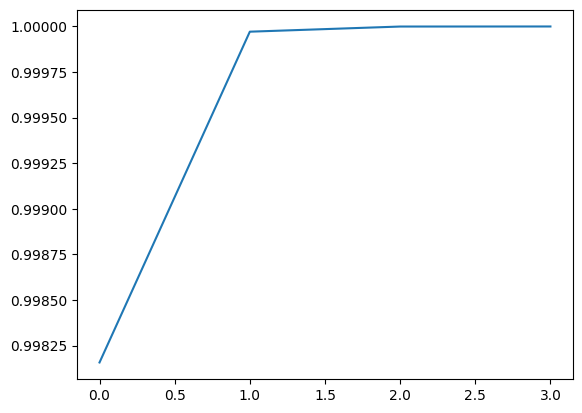

In [32]:
#plot: pca.explained_variance_ratio_
sns.lineplot(x=range(len(pca.explained_variance_ratio_)), y=np.cumsum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_) # the first component explains 99% of the variance
print(pca.components_)

## 3.3
Vector representation of the documents using three different procedures:

### TF-IDF

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

# nltk.download('stopwords')

In [34]:
def get_tfidf_matrix(data, filter_treshold=0.0001):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    joined_textual_columns = data[textual_columns].apply(lambda x: ' '.join(x), axis=1)
    tfidf_matrix = tfidf_vectorizer.fit_transform(joined_textual_columns)
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    tfidf_df = tfidf_df.loc[:, tfidf_df.columns[(tfidf_df != 0).mean() > filter_treshold]] #reduce from 20568 columns
    return tfidf_df

In [35]:
if not runs_on_gpu:
    tfidf = get_tfidf_matrix(data) 
    tfidf.to_hdf('local_store.h5', key='tfidf')
    tfidf

### Word2Vec (i.e., representing the documents as the average of the embeddings of the words that make them up)

In [36]:
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings

warnings.filterwarnings(action='ignore')
#nltk.download('punkt_tab')

In [37]:
def get_word2vec_for_cell(text):
	all_words = []

	for sentence in sent_tokenize(text):
		words = []
		for word in word_tokenize(sentence):
			words.append(word.lower())

		all_words.append(words)

	model = Word2Vec(all_words, min_count=1)

	return model.wv

def get_avrg_word2vec(text):
	if(text.strip() == ''):
		return pd.NA

	word_vectors = get_word2vec_for_cell(text)

	return np.mean(word_vectors.vectors, axis=0)

def get_word2vec(data):
	word2vec_dict = {}
	for column in textual_columns:
		print(f"Start processing column {column}")
		word2vec_dict[column] = data[column].apply(get_avrg_word2vec)
		print(f"Finished processing column {column}")

	return pd.DataFrame(word2vec_dict)

In [38]:
if not runs_on_gpu:
    word2vec = get_word2vec(data)
    word2vec.to_hdf('local_store.h5', key='word2vec')
    word2vec

Start processing column title


KeyboardInterrupt: 

### Contextual embeddings calculated from transformer-based models (e.g., BERT, RoBERTa, etc.)

In [51]:
from transformers import BertModel, BertTokenizer # type: ignore

In [87]:
def prepare_input(texts, tokenizer):
    return tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

def get_context_embeddings_batch(texts, model, tokenizer, batch_size=450):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        print(i)
        batch_texts = texts[i:i + batch_size]
        inputs = prepare_input(batch_texts, tokenizer)
        inputs = inputs.to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy()
        all_embeddings.extend(embeddings)
    
    return np.array(all_embeddings, dtype='float32')

def get_context_embedding_for_text_columns(data, textual_columns):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    model.to(device)

    embedded_textual_columns = list()
    for column in textual_columns:
        print(f'Processing column {column}')
        texts = data[column].tolist()  # Convert to list for batch processing
        embeddings = get_context_embeddings_batch(texts, model, tokenizer)
        embedded_textual_columns.append(embeddings)
        
    return np.array(embedded_textual_columns)

In [88]:
if runs_on_gpu:
    context_embedding = get_context_embedding_for_text_columns(data, textual_columns)
    np.save("context_embedding.npy", context_embedding)
else:
    context_embedding = get_context_embedding_for_text_columns(data.sample(5), textual_columns)
context_embedding

Processing column title
0
Processing column directions
0
Processing column desc
0


array([[[ 0.00378332,  0.00232491, -0.05093493, ..., -0.19126444,
         -0.05834966, -0.31831014],
        [-0.10734759, -0.12043882,  0.07180182, ...,  0.31760633,
          0.1573991 , -0.14559318],
        [ 0.04495081,  0.07077776,  0.05987082, ..., -0.043982  ,
          0.17460601, -0.00705606],
        [-0.42040265, -0.10202532, -0.19609334, ...,  0.04962611,
         -0.08204118,  0.06964585],
        [-0.1284027 , -0.19521289, -0.20540003, ..., -0.01678804,
         -0.09491558, -0.22409669]],

       [[-0.28318965,  0.0607651 ,  0.13650429, ...,  0.06853717,
         -0.03409788,  0.08850215],
        [-0.38609508,  0.1308566 ,  0.26758346, ..., -0.04735008,
         -0.02301   ,  0.20024462],
        [-0.1840464 , -0.05251806,  0.32388303, ..., -0.11353022,
         -0.08170391,  0.09819675],
        [-0.22461653,  0.01889488,  0.19226694, ..., -0.05330233,
         -0.03001274,  0.08836985],
        [ 0.05341099, -0.12399442,  0.14675067, ...,  0.1106676 ,
         -0.07

## 3.4
Training and evaluation of regression models using at least the following two machine learning strategies:
- Neural networks using PyTorch for implementation.
- At least one other technique implemented in the Scikit-learn library
(e.g., K-NN, SVM, Random Forest, etc.)

### Neural networks using PyTorch for implementation.

In [4]:
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [114]:
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, int(input_size/2))
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(int(input_size/2), 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x       

In [118]:
#embeddings = pd.read_hdf('local_store.h5', key='tfidf').to_numpy()
#embeddings = pd.read_hdf('local_store.h5', key='word2vec').to_numpy()
embeddings = np.load("context_embedding.npy")
embeddings = embeddings.reshape(embeddings.shape[0], -1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(embeddings, ratings.to_numpy(), test_size=0.2, random_state=42)

Training Matrix:  torch.Size([16080, 2304]) torch.Size([16080, 1])
Test Matrix:  (4020, 2304)
input_size:  2304
Epoch [1/100], Loss: 15.6339
Epoch [11/100], Loss: 2.1760
Epoch [21/100], Loss: 1.8882
Epoch [31/100], Loss: 1.7643
Epoch [41/100], Loss: 1.6725
Epoch [51/100], Loss: 1.6269
Epoch [61/100], Loss: 1.5968
Epoch [71/100], Loss: 1.5773
Epoch [81/100], Loss: 1.5627
Epoch [91/100], Loss: 1.5476
Epoch [100/100], Loss: 1.5336
Test Loss: 1.6349
Compared to baseline mse: 110%


In [ ]:

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
y_train_tensor = y_train_tensor.unsqueeze(1)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)
y_test_tensor = y_test_tensor.unsqueeze(1)

print('Training Matrix: ', X_train_tensor.shape, y_train_tensor.shape)
print('Test Matrix: ', X_test.shape)
 
input_size = X_train.shape[1]
print('input_size: ', input_size)

model = RegressionModel(input_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    outputs = model(X_train_tensor)
    
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch % 10 == 0):
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    model.eval()
    test_outputs = torch.round(model(X_test_tensor))
    
test_loss = criterion(test_outputs, y_test_tensor)
print(f'Test Loss: {test_loss.item():.4f}')
print(f"Compared to baseline mse: {baseline_mse / test_loss * 100:.0f}%")

### - At least one other technique implemented in the Scikit-learn library
(e.g., K-NN, SVM, Random Forest, etc.)

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [122]:
from sklearn.ensemble import RandomForestRegressor

In [123]:
rf_x = data[numerical_columns].copy()
rf_x['rating'] = data['rating']
rf_x.dropna(how='any', inplace=True)
rf_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15896 entries, 0 to 20099
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fat       15896 non-null  float64
 1   calories  15896 non-null  float64
 2   protein   15896 non-null  float64
 3   sodium    15896 non-null  float64
 4   rating    15896 non-null  float64
dtypes: float64(5)
memory usage: 745.1 KB


In [124]:
X_train, X_test, y_train, y_test = train_test_split(rf_x[numerical_columns], rf_x['rating'], test_size=0.2, random_state=42)

In [125]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)

RandomForestRegressor()

In [126]:
y_pred = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

mean_error = np.mean(np.abs(y_test - y_pred))
print(mean_error)

score = rf_regressor.score(X_test, y_test)
print(score)

print(f"Compared to baseline mse: {baseline_mse / mse * 100:.0f}%")

1.4590357331597468
0.7948702971569578
0.1424960712118577
Compared to baseline mse: 124%


## 3.5
Comparison of the results obtained in step 3 with fine-tuning a pre-trained model from Hugging Face. In this step, you are asked to use a transformer model with a regression head.

In [11]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split  

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
X = data['directions'].tolist()
y = ratings.to_numpy(dtype='float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, y_train)
test_dataset = Dataset(test_encodings, y_test)

model.to(device)

training_args = TrainingArguments(
    output_dir='./results', # Output directory
    num_train_epochs=3, # Number of epochs
    per_device_train_batch_size=16, # Training batch size
    per_device_eval_batch_size=64, # Evaluation batch size
    warmup_steps=500, # Warmup steps
    weight_decay=0.01, # Weight decay
    logging_dir='./logs', # Logging directory
    logging_steps=10,
)

trainer = Trainer(
    model=model, # Pre-trained model
    args=training_args, # Training arguments
    train_dataset=train_dataset, # Training data
    eval_dataset=test_dataset # Evaluation data
)

print("Start training")

# Start fine-tuning
trainer.train()

# Evaluate the model
trainer.evaluate()

# Save the fine-tuned model
model.save_pretrained('./fine-tuned-bert')
tokenizer.save_pretrained('./fine-tuned-bert')

Start training


                                        
  0%|          | 0/3015 [05:41<?, ?it/s]         

{'loss': 13.6354, 'grad_norm': 110.56185913085938, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}


                                        
  0%|          | 0/3015 [05:44<?, ?it/s]         

{'loss': 12.4936, 'grad_norm': 127.78746032714844, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}


                                        
  0%|          | 0/3015 [05:48<?, ?it/s]         

{'loss': 10.6723, 'grad_norm': 95.80782318115234, 'learning_rate': 3e-06, 'epoch': 0.03}


                                        
  0%|          | 0/3015 [05:51<?, ?it/s]         

{'loss': 8.7736, 'grad_norm': 114.6506118774414, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}


                                        
  0%|          | 0/3015 [05:55<?, ?it/s]         

{'loss': 7.0099, 'grad_norm': 84.49993896484375, 'learning_rate': 5e-06, 'epoch': 0.05}


KeyboardInterrupt: 

## 4
### Extension
Generate new recipes based on random ingredients

In [41]:
number_of_ingredients = np.random.randint(4, 8)
random_ingredients = []
for i in range(number_of_ingredients):
    ingredients = data['ingredients'].sample().iloc[0]
    if len(ingredients) == 0:
        continue
    random_ingredient = ingredients[np.random.randint(0, len(ingredients))]
    random_ingredients.append(random_ingredient)

print(random_ingredients)

['1 1/2 teaspoons kosher salt', '2 teaspoons ground coriander', '1 1/2 pounds boiling potatoes such as Yukon Gold', 'Nonstick vegetable oil spray', '1 large rutabaga, about 1 1/2 pounds']


### 4.1
Fine tune transformer to give directions for random ingredients

In [14]:
from transformers import BertTokenizer, BertGenerationPreTrainedModel
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertGenerationPreTrainedModel.from_pretrained('bert-base-uncased')

You are using a model of type bert to instantiate a model of type bert-generation. This is not supported for all configurations of models and can yield errors.


StopIteration: 

In [9]:
X = data['ingredients'].tolist()
y = data['directions'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, y_train)
test_dataset = Dataset(test_encodings, y_test)

model.to(device)

training_args = TrainingArguments(
    output_dir='./results', # Output directory
    num_train_epochs=3, # Number of epochs
    per_device_train_batch_size=16, # Training batch size
    per_device_eval_batch_size=64, # Evaluation batch size
    warmup_steps=500, # Warmup steps
    weight_decay=0.01, # Weight decay
    logging_dir='./logs', # Logging directory
    logging_steps=10,
)

trainer = Trainer(
    model=model, # Pre-trained model
    args=training_args, # Training arguments
    train_dataset=train_dataset, # Training data
    eval_dataset=test_dataset # Evaluation data
)

print("Start training")

# Start fine-tuning
trainer.train()

# Evaluate the model
trainer.evaluate()

# Save the fine-tuned model
model.save_pretrained('./fine-tuned-bert')
tokenizer.save_pretrained('./fine-tuned-bert')

### 4.2
Compare to directions and title made by groq

In [ ]:
from groq import Groq
import os
from dotenv import load_dotenv
import json

In [42]:
load_dotenv()

API_KEY = os.getenv('API_KEY')

client = Groq(
    api_key=API_KEY
)

prompt = f'I have following ingredients: {random_ingredients}. Give title and directions for a recipe. Your answer is a json-file, so i can parse you answer programmatically. The json looks like this: {{ "title" : "title", "directions" : ["direction1","direction2"] }}'

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": prompt,
        }
    ],
    model="llama3-8b-8192",
)
reply = chat_completion.choices[0].message.content
print(reply)


Here is the JSON file for the recipe:

```
{
  "title": "Roasted Root Vegetables with Coriander and Salt",
  "directions": [
    "Preheat the oven to 425°F (220°C).",
    "Peel the potatoes and rutabaga, and cut them into 1-inch (2.5 cm) cubes.",
    "In a medium bowl, whisk together the kosher salt and ground coriander.",
    "Add the potato and rutabaga cubes to the bowl and toss until they are evenly coated with the salt and spice mixture.",
    "Spray a large baking sheet with nonstick vegetable oil spray.",
    "Spread the potato and rutabaga mixture out in a single layer on the prepared baking sheet.",
    "Roast in the preheated oven for 40-45 minutes, or until the vegetables are tender and lightly caramelized.",
    "Serve hot, garnished with fresh herbs or a dollop of sour cream if desired."
  ]
}
```

You can parse this JSON data programmatically using any programming language that supports JSON parsing, such as JavaScript, Python, or Java.


In [49]:
new_recipe = reply[reply.find('```')+3:reply.rfind('```')]
new_recipe = json.loads(new_recipe)
new_recipe['ingredients'] = random_ingredients

new_recipes = pd.read_json('new_recipes.json')

new_recipe = pd.DataFrame([new_recipe])
new_recipes = pd.concat([new_recipes, new_recipe], ignore_index=True)
new_recipes.to_json('new_recipes.json')

new_recipes.head()

,title,directions,ingredients
0,Shrimp with Apricot Glaze and Salt,"[Preheat oven to 400°F (200°C)., In a small bo...","[2 tbsp/20 g finely chopped red onion, 3 table..."
1,Roasted Root Vegetables with Coriander and Salt,"[Preheat the oven to 425°F (220°C)., Peel the ...","[1 1/2 teaspoons kosher salt, 2 teaspoons grou..."


In [48]:
new_recipe

{'title': 'Roasted Root Vegetables with Coriander and Salt',
 'directions': ['Preheat the oven to 425°F (220°C).',
  'Peel the potatoes and rutabaga, and cut them into 1-inch (2.5 cm) cubes.',
  'In a medium bowl, whisk together the kosher salt and ground coriander.',
  'Add the potato and rutabaga cubes to the bowl and toss until they are evenly coated with the salt and spice mixture.',
  'Spray a large baking sheet with nonstick vegetable oil spray.',
  'Spread the potato and rutabaga mixture out in a single layer on the prepared baking sheet.',
  'Roast in the preheated oven for 40-45 minutes, or until the vegetables are tender and lightly caramelized.',
  'Serve hot, garnished with fresh herbs or a dollop of sour cream if desired.'],
 'ingredients': ['1 1/2 teaspoons kosher salt',
  '2 teaspoons ground coriander',
  '1 1/2 pounds boiling potatoes such as Yukon Gold',
  'Nonstick vegetable oil spray',
  '1 large rutabaga, about 1 1/2 pounds']}